In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import geopandas

from IPython.display import Image, Audio, clear_output

import os

import re
from textblob import TextBlob

import pysal as ps

import pickle

from shapely.geometry import shape, Point
from shapely import geometry

from ast import literal_eval as make_tuple

from sklearn import preprocessing
import sklearn.decomposition

from zipfile import ZipFile

from tqdm import tnrange, tqdm_notebook

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from notify_run import Notify

import torch

base_path = "lawrence_leavenworth"

%matplotlib inline

In [2]:
# tracts = geopandas.read_file("tiger_shapes/")
tracts = geopandas.read_file('tiger_groups/')

In [3]:
tracts.shape

(2351, 13)

In [4]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,20,205,097300,2,202050973002,Block Group 2,G5030,S,12265130,123713,+37.5320365,-095.8438527,"POLYGON ((-95.87000999999999 37.539666, -95.86..."
1,20,137,951700,3,201379517003,Block Group 3,G5030,S,1683677,0,+39.8322507,-099.8975827,"POLYGON ((-99.91362199999999 39.82805, -99.912..."
2,20,137,951700,1,201379517001,Block Group 1,G5030,S,267077152,0,+39.8554657,-099.7448026,"POLYGON ((-99.85198 39.770469, -99.85183099999..."
3,20,137,951700,2,201379517002,Block Group 2,G5030,S,33200975,0,+39.8521347,-099.9015382,"POLYGON ((-99.945278 39.840666, -99.945252 39...."
4,20,137,951700,5,201379517005,Block Group 5,G5030,S,1923579801,8421464,+39.5762745,-100.1843757,"POLYGON ((-100.180456 39.577752, -100.180423 3..."


In [5]:
ksdata = pd.read_csv('nhgis0006_csv/nhgis0006_ds172_2010_blck_grp.csv', low_memory=False)

In [6]:
keys = {}

# with open("NC/nhgis0008_csv/nhgis0008_ds172_2010_blck_grp_codebook.txt", "r") as labels:
with open("nhgis0006_csv/codebook_processed.txt", "r") as labels:
    for line in labels:
        formatted = line.split(":", 1)
        key = formatted[0].strip()
        val = formatted[1].strip()
        keys[key] = val
        
keys

{'GISJOIN': 'GIS Join Match Code',
 'YEAR': 'Data File Year',
 'REGIONA': 'Region Code',
 'DIVISIONA': 'Division Code',
 'STATE': 'State Name',
 'STATEA': 'State Code',
 'COUNTY': 'County Name',
 'COUNTYA': 'County Code',
 'COUSUBA': 'County Subdivision Code',
 'PLACEA': 'Place Code',
 'TRACTA': 'Census Tract Code',
 'BLKGRPA': 'Block Group Code',
 'BLOCKA': 'Block Code',
 'CONCITA': 'Consolidated City Code',
 'RES_ONLYA': 'American Indian Reservation with Trust Lands; reservation only Code',
 'TRUSTA': 'American Indian Reservation with Trust Lands; trust lands only Code',
 'AIANHHA': 'American Indian Area/Alaska Native Area/Hawaiian Home Land Code',
 'AITSCEA': 'Tribal Subdivision/Remainder Code',
 'TTRACTA': 'Tribal Census Tract Code',
 'TBLKGRPA': 'Tribal Block Group Code',
 'ANRCA': 'Alaska Native Regional Corporation Code',
 'CBSAA': 'Metropolitan Statistical Area/Micropolitan Statistical Area Code',
 'METDIVA': 'Metropolitan Division Code',
 'CSAA': 'Combined Statistical Area Cod

In [7]:
ksdata["GEOID"] = ksdata.apply(lambda x: x["GISJOIN"][1:2] + x["GISJOIN"][3:7] + x["GISJOIN"][8:], axis=1)
# ksdata['GEOID'] = ksdata['GEOID10']

ksdata.shape

(2351, 113)

In [8]:
# joined = tracts.merge(ksdata, how='left', on='GEOID10')

tracts = tracts.sort_values("GEOID")

tracts.shape

(2351, 13)

In [9]:
joined = tracts.merge(ksdata, how="left", on="GEOID")

joined = joined.sort_values("GEOID")

joined.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,H76040,H76041,H76042,H76043,H76044,H76045,H76046,H76047,H76048,H76049
0,20,001,952600,1,200019526001,Block Group 1,G5030,S,701604844,4345778,...,76,82,34,29,20,33,47,43,36,45
1,20,001,952700,1,200019527001,Block Group 1,G5030,S,208834197,1948759,...,61,36,17,19,10,17,35,17,13,10
2,20,001,952700,2,200019527002,Block Group 2,G5030,S,30850689,379388,...,41,40,21,18,11,13,22,19,24,10
3,20,001,952800,1,200019528001,Block Group 1,G5030,S,12210392,281446,...,50,44,14,26,9,24,25,19,26,40
4,20,001,952800,2,200019528002,Block Group 2,G5030,S,18136994,183991,...,59,44,19,22,11,28,25,34,37,44


In [10]:
new = [keys[col] if col in list(keys.keys()) else col for col in joined.columns]

joined.columns = new
    

In [11]:
county_file = open('counties.txt', 'r')
counties = county_file.read().strip()
counties = counties.replace(' ', '').split(',')
counties = [x + ' County' for x in counties]

counties = list(joined['County Name'].unique())

print(counties)
county_file.close()



['Allen County', 'Anderson County', 'Atchison County', 'Barber County', 'Barton County', 'Bourbon County', 'Brown County', 'Butler County', 'Chase County', 'Chautauqua County', 'Cherokee County', 'Cheyenne County', 'Clark County', 'Clay County', 'Cloud County', 'Coffey County', 'Comanche County', 'Cowley County', 'Crawford County', 'Decatur County', 'Dickinson County', 'Doniphan County', 'Douglas County', 'Edwards County', 'Elk County', 'Ellis County', 'Ellsworth County', 'Finney County', 'Ford County', 'Franklin County', 'Geary County', 'Gove County', 'Graham County', 'Grant County', 'Gray County', 'Greeley County', 'Greenwood County', 'Hamilton County', 'Harper County', 'Harvey County', 'Haskell County', 'Hodgeman County', 'Jackson County', 'Jefferson County', 'Jewell County', 'Johnson County', 'Kearny County', 'Kingman County', 'Kiowa County', 'Labette County', 'Lane County', 'Leavenworth County', 'Lincoln County', 'Linn County', 'Logan County', 'Lyon County', 'McPherson County', 'M

In [12]:
douglas = joined.loc[joined['County Name'].isin(counties)]

(2351, 125)

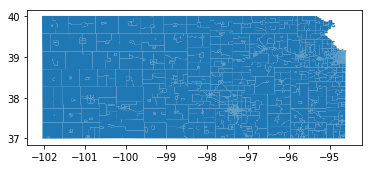

In [13]:
douglas.plot()

douglas.shape

In [14]:
county_codes = douglas[['COUNTYFP', 'County Name']]
county_codes.drop_duplicates(inplace=True)

county_codes.set_index('COUNTYFP', inplace=True)

county_codes.head()

C:\Users\jxbox\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,County Name
COUNTYFP,
001,Allen County
003,Anderson County
005,Atchison County
007,Barber County
009,Barton County


In [15]:
douglas.COUNTYFP.value_counts()

091    374
173    369
209    161
177    135
045     65
155     59
103     50
161     48
169     45
015     42
125     37
037     34
035     33
111     32
121     30
055     30
009     30
113     29
079     27
191     26
051     25
061     25
057     25
059     23
099     22
021     21
041     19
133     18
175     17
011     16
      ... 
097      4
065      4
135      4
119      4
105      4
017      4
141      4
165      4
179      4
081      4
047      4
089      4
023      4
039      4
185      4
203      3
129      3
063      3
101      3
109      3
033      3
153      3
093      3
075      2
071      2
199      2
025      2
207      2
187      2
083      1
Name: COUNTYFP, Length: 105, dtype: int64

173    447
091    444
177    227
209    111
045     95
015     81
155     80
161     71
035     69
169     64
037     62
061     61
125     60
121     59
021     54
111     53
103     52
009     50
191     47
079     44
099     42
051     39
131     38
041     36
115     35
117     34
113     34
123     33
055     32
057     32
      ... 
047     13
043     13
107     13
109     12
137     12
207     11
195     11
083     11
017     11
171     11
135     11
189     11
101     10
075     10
129     10
049     10
093      9
119      9
063      9
081      8
069      8
023      8
025      7
097      5
067      5
199      5
033      4
187      3
071      3
203      3
Name: COUNTYFP10, Length: 105, dtype: int64

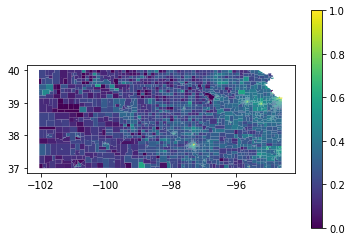

In [16]:
elec = geopandas.read_file("elections")
elec.COUNTYFP10.value_counts()

# elec = elec.loc[elec['COUNTYFP10'].isin(["045", "059", "139", "177", "087", "103"])]
elec = elec.loc[elec['COUNTYFP10'].isin(list(county_codes.index))]
elec['lean'] = elec['PRES_D_08'] / (elec['PRES_D_08'] + elec['PRES_R_08'] + 1e-10)

elec.plot("lean", legend=True)

elec.COUNTYFP10.value_counts()

In [17]:
voting_age = ["Female: 18 and 19 years", "Female: 20 years", "Female: 21 years", "Female: 22 to 24 years", 
    "Female: 25 to 29 years", "Female: 30 to 34 years", "Female: 35 to 39 years", "Female: 40 to 44 years",
    "Female: 45 to 49 years", "Female: 50 to 54 years", "Female: 55 to 59 years", 'Female: 60 and 61 years',
    'Female: 62 to 64 years', 'Female: 65 and 66 years', 'Female: 67 to 69 years', 'Female: 70 to 74 years',
    'Female: 75 to 79 years', 'Female: 80 to 84 years', 'Female: 85 years and over', 'Male: 18 and 19 years',
    'Male: 20 years', 'Male: 21 years', 'Male: 22 to 24 years', 'Male: 25 to 29 years', 'Male: 30 to 34 years',
    'Male: 35 to 39 years', 'Male: 40 to 44 years', 'Male: 45 to 49 years', 'Male: 50 to 54 years', 'Male: 55 to 59 years',
    'Male: 60 and 61 years', 'Male: 62 to 64 years', 'Male: 65 and 66 years', 'Male: 67 to 69 years', 'Male: 70 to 74 years',
    'Male: 75 to 79 years', 'Male: 80 to 84 years', 'Male: 85 years and over']

def compute_votes(i):
    r_votes = 0.0
    d_votes = 0.0
    for j in elec[elec['COUNTYFP10'] == i.COUNTYFP].index:
        intersec = elec.loc[j].geometry.intersection(i.geometry).area
        if intersec > 0: 
            inter_pct = elec.loc[j].geometry.intersection(i.geometry).area / i.geometry.area
            elig = i[voting_age].sum()
            r_votes += (elig * inter_pct / (elec.loc[j]["VAP"] + 1e-10)) * elec.loc[j]["PRES_R_08"]
            d_votes += (elig * inter_pct / (elec.loc[j]["VAP"] + 1e-10)) * elec.loc[j]["PRES_D_08"]
    if list(i['Total'])[0] < d_votes or list(i['Total'])[0] < r_votes or list(i['Total'])[0] < d_votes + r_votes:
        r_votes *= (elig / list(i['Total'])[0])
        d_votes *= (elig / list(i['Total'])[0])
        
    return (r_votes, d_votes)

ddouglas = dd.from_pandas(douglas, npartitions=24)

with ProgressBar():
    douglas['vote_tuple'] = ddouglas.map_partitions(lambda df: df.apply((lambda x: compute_votes(x)), axis=1), meta=(float, float)).compute(scheduler='processes')

douglas['2008_R'] = douglas.apply((lambda x: x['vote_tuple'][0]), axis=1)
douglas['2008_D'] = douglas.apply((lambda x: x['vote_tuple'][1]), axis=1)

[########################################] | 100% Completed | 40.6s


In [18]:
douglas.fillna(0.0, inplace=True)

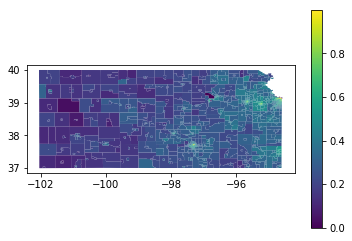

In [19]:
douglas['lean'] = douglas['2008_D'] / (douglas['2008_D'] + douglas['2008_R'] + 1e-10)
douglas.plot("lean", legend=True)
douglas.drop('lean', axis=1, inplace=True)
douglas.drop('vote_tuple', axis=1, inplace=True)

In [20]:
# douglas.to_file(base_path)
# rw = ps.rook_from_shapefile(base_path + '/' + base_path + '.shp')

In [21]:
rw = ps.lib.weights.Rook(list(douglas['geometry']), ids=range(len(douglas['geometry'])))

In [22]:
neighbors = []
for i in rw:
    neighbors.append(list(i[1].keys()))

In [23]:
pkl_file = open(base_path + '_neighbors.pkl', 'wb')
pickle.dump(neighbors, pkl_file)
pkl_file.close()

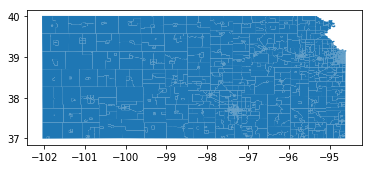

In [25]:
block_groups = geopandas.read_file("occupation/nhgis0003_shape/")

occs = pd.read_csv("occupation/nhgis0003_csv/nhgis0004_ds176_20105_2010_blck_grp.csv")
occs["GEOID10"] = occs.apply(lambda x:x["GISJOIN"][1:2] + x["GISJOIN"][3:7] + x["GISJOIN"][8:], axis=1)

block_groups = block_groups.merge(occs, on='GEOID10', how='left')

block_groups.plot()

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'GEOID10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       ...
       'JQ5M069', 'JQ5M070', 'JQ5M071', 'JQ5M072', 'JQ5M073', 'MBSA', 'S',
       'SO', 'NRCM', 'PTM'],
      dtype='object', length=201)

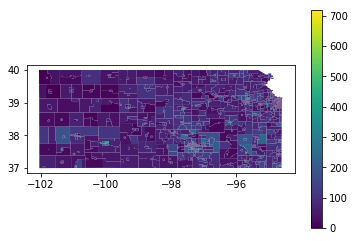

In [26]:
block_groups['MBSA'] = (block_groups['JQ5E003'] + block_groups['JQ5E039'])
block_groups['S'] = (block_groups['JQ5E019'] + block_groups['JQ5E055'])
block_groups['SO'] = (block_groups['JQ5E027'] + block_groups['JQ5E063'])
block_groups['NRCM'] = (block_groups['JQ5E030'] + block_groups['JQ5E066'])
block_groups['PTM'] = (block_groups['JQ5E034'] + block_groups['JQ5E070'])

block_groups.plot("PTM", legend=True)

block_groups.columns

In [27]:
work_age = ["Male: 15 to 17 years", "Female: 15 to 17 years", "Female: 18 and 19 years", "Female: 20 years", "Female: 21 years", "Female: 22 to 24 years", 
    "Female: 25 to 29 years", "Female: 30 to 34 years", "Female: 35 to 39 years", "Female: 40 to 44 years",
    "Female: 45 to 49 years", "Female: 50 to 54 years", "Female: 55 to 59 years", 'Female: 60 and 61 years',
    'Female: 62 to 64 years', 'Female: 65 and 66 years', 'Female: 67 to 69 years', 'Female: 70 to 74 years',
    'Female: 75 to 79 years', 'Female: 80 to 84 years', 'Female: 85 years and over', 'Male: 18 and 19 years',
    'Male: 20 years', 'Male: 21 years', 'Male: 22 to 24 years', 'Male: 25 to 29 years', 'Male: 30 to 34 years',
    'Male: 35 to 39 years', 'Male: 40 to 44 years', 'Male: 45 to 49 years', 'Male: 50 to 54 years', 'Male: 55 to 59 years',
    'Male: 60 and 61 years', 'Male: 62 to 64 years', 'Male: 65 and 66 years', 'Male: 67 to 69 years', 'Male: 70 to 74 years',
    'Male: 75 to 79 years', 'Male: 80 to 84 years', 'Male: 85 years and over']

def compute_occupations(i):
    mbsa = 0.0
    s = 0.0
    so = 0.0
    nrcm = 0.0
    ptm = 0.0
    for j in block_groups[block_groups['COUNTYFP10'] == i.COUNTYFP].index:
        intersec = block_groups.loc[j].geometry.intersection(i.geometry).area
        if intersec > 0 and block_groups.loc[j]['JQ5E001'] > 0: 
            inter_pct = block_groups.loc[j].geometry.intersection(i.geometry).area / i.geometry.area
            elig = i[work_age].sum()
            mbsa += (elig * inter_pct / (block_groups.loc[j]['JQ5E001'] + 1e-10)) * block_groups.loc[j]["MBSA"]
            s += (elig * inter_pct / (block_groups.loc[j]['JQ5E001'] + 1e-10)) * block_groups.loc[j]["S"]
            so += (elig * inter_pct / (block_groups.loc[j]['JQ5E001'] + 1e-10)) * block_groups.loc[j]["SO"]
            nrcm += (elig * inter_pct / (block_groups.loc[j]['JQ5E001'] + 1e-10)) * block_groups.loc[j]["NRCM"]
            ptm += (elig * inter_pct / (block_groups.loc[j]['JQ5E001'] + 1e-10)) * block_groups.loc[j]["PTM"]
#     if list(i['Total'])[0] < d_votes or list(i['Total'])[0] < r_votes or list(i['Total'])[0] < d_votes + r_votes:
#         r_votes *= (elig / list(i['Total'])[0])
#         d_votes *= (elig / list(i['Total'])[0])
        
    return (mbsa, s, so, nrcm, ptm)

ddouglas = dd.from_pandas(douglas, npartitions=24)

with ProgressBar():
    douglas['vote_tuple'] = ddouglas.map_partitions(lambda df: df.apply((lambda x: compute_occupations(x)), axis=1), meta=(float)).compute(scheduler='processes')

print('finished map')
douglas['MBSA'] = douglas.apply((lambda x: x['vote_tuple'][0]), axis=1)
douglas['S'] = douglas.apply((lambda x: x['vote_tuple'][1]), axis=1)
douglas['SO'] = douglas.apply((lambda x: x['vote_tuple'][2]), axis=1)
douglas['NRCM'] = douglas.apply((lambda x: x['vote_tuple'][3]), axis=1)
douglas['PTM'] = douglas.apply((lambda x: x['vote_tuple'][4]), axis=1)

douglas.fillna(0.0, inplace=True)
douglas.drop('vote_tuple', axis=1, inplace=True)
print('finished drop')

[########################################] | 100% Completed | 39.9s
finished map
finished drop


In [28]:
douglas.to_file(base_path)

C:\Users\jxbox\Anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [29]:
douglas = geopandas.read_file(base_path)

In [30]:
douglas["Total_Pop"] = douglas["Total"]

douglas["Non_His_White_Pct"] = douglas["Not Hisp_1"] / (douglas["Total_Pop"] + 1e-10)
douglas["His_Pct"] = douglas["Hispanic o"] / (douglas["Total_Pop"] + 1e-10)
douglas["Afr_Pct"] = douglas["Not Hisp_2"] / (douglas["Total_Pop"] + 1e-10)
douglas["NA_Pct"] = douglas["Not Hisp_3"] / (douglas["Total_Pop"] + 1e-10)
douglas["Asn_Pct"] = douglas["Not Hisp_4"] / (douglas["Total_Pop"] + 1e-10)
douglas["HA_Pct"] = douglas["Not Hisp_5"] / (douglas["Total_Pop"] + 1e-10)
douglas["Oth_Pct"] = douglas["Not Hisp_6"] / (douglas["Total_Pop"] + 1e-10)
douglas["Two_Pct"] = douglas["Not Hisp_7"] / (douglas["Total_Pop"] + 1e-10)

douglas["Urb_Pct"] = douglas["Urban"] / (douglas["Total_Pop"] + 1e-10)
douglas["Rur_Pct"] = douglas["Rural"] / (douglas["Total_Pop"] + 1e-10)

douglas['MBSA_Pct'] = douglas["MBSA"] / (douglas["Total_Pop"] + 1e-10)
douglas['S_Pct'] = douglas["S"] / (douglas["Total_Pop"] + 1e-10)
douglas['SO_Pct'] = douglas["SO"] / (douglas["Total_Pop"] + 1e-10)
douglas['NRCM_Pct'] = douglas["NRCM"] / (douglas["Total_Pop"] + 1e-10)
douglas['PTM_Pct'] = douglas["PTM"] / (douglas["Total_Pop"] + 1e-10)

douglas['R_Pct'] = douglas['2008_R'] / (douglas['2008_R'] + douglas['2008_D'] + 1e-10)
douglas['D_Pct'] = douglas['2008_D'] / (douglas['2008_R'] + douglas['2008_D'] + 1e-10)

douglas.replace([np.inf, -np.inf], np.nan)

douglas.fillna(0, inplace=True)

In [31]:
racial_attrs = dict([(i, np.array([douglas.loc[i].Non_His_White_Pct, 
                                   douglas.loc[i].His_Pct, douglas.loc[i].Afr_Pct, 
                                   douglas.loc[i].NA_Pct, douglas.loc[i].Asn_Pct, 
                                   douglas.loc[i].Urb_Pct, douglas.loc[i].MBSA_Pct,
                                   douglas.loc[i].S_Pct, douglas.loc[i].SO_Pct,
                                   douglas.loc[i].NRCM_Pct, douglas.loc[i].PTM_Pct])) for i in douglas.index])

In [32]:
def get_centroid(i):
    return i.geometry.centroid

# type(douglas.iloc[0].geometry.centroid)

ddouglas = dd.from_pandas(douglas, npartitions=12)

douglas['centroid'] = ddouglas.map_partitions(lambda df: df.apply((lambda x: get_centroid(x)), axis=1), meta=geometry.point.Point).compute(scheduler='processes')


In [33]:
attrs = [racial_attrs[i] for i in douglas.index]

centroids = [douglas.loc[i].centroid for i in douglas.index]
xs = np.matrix([c.x for c in centroids]).T
ys = np.matrix([c.y for c in centroids]).T

attrs = np.matrix(attrs)

# print(attrs.shape, xs.shape, ys.shape)

minmax_xs = preprocessing.MinMaxScaler().fit_transform(xs)
minmax_ys = preprocessing.MinMaxScaler().fit_transform(ys)

attrs = np.append(attrs, minmax_xs, axis=1)
attrs = np.append(attrs, minmax_ys, axis=1)

attrs = preprocessing.RobustScaler().fit_transform(attrs)

# print(attrs.shape, xs.shape, ys.shape)

# xs = preprocessing.QuantileTransformer().fit_transform(xs)
# ys = preprocessing.QuantileTransformer().fit_transform(ys)

attrs = np.append(attrs, xs, axis=1)
attrs = np.append(attrs, ys, axis=1)

print(len([douglas['Total_Pop'][i] for i in douglas.index]))
# print([douglas['Total_Pop'][i] for i in douglas.index][0])

attrs = np.append(attrs, np.array([douglas['Total_Pop'][i] for i in douglas.index]).reshape(-1,1), axis=1)

attrs[:3]

2351


matrix([[ 3.98909873e-01, -3.88060741e-01, -2.32822179e-01,
          4.61209687e-01, -3.41189815e-01, -1.00905991e+00,
          3.90278130e-02, -6.48904405e-01, -3.98050426e-01,
          8.11171838e-01,  9.09164210e-01,  4.23774618e-01,
         -6.94408789e-01, -9.52036190e+01,  3.78738289e+01,
          2.01100000e+03],
        [ 4.03972868e-01, -4.37388959e-01, -2.63168067e-01,
          9.96399183e-01,  8.05472155e-02, -1.00905991e+00,
         -6.07076680e-01,  2.40929668e-01, -2.11592719e-01,
          8.46688555e-01,  1.01428389e+00,  3.54352686e-01,
         -6.08885825e-01, -9.53806654e+01,  3.79871957e+01,
          1.14100000e+03],
        [ 4.84331549e-01, -4.13444623e-01, -3.69965606e-01,
          7.69033630e-01, -3.89700521e-01, -1.00905991e+00,
         -2.75241004e-01, -1.55142449e-01, -2.91793979e-02,
          2.27850003e-01,  9.91197440e-01,  3.68477754e-01,
         -6.69062508e-01, -9.53446424e+01,  3.79074272e+01,
          1.03300000e+03]])

In [34]:
douglas.drop('centroid', inplace=True, axis=1)

attr_tensor = torch.from_numpy(attrs).float()
torch.save(attr_tensor, base_path + '_data_tensor.pt')
douglas.to_file(base_path)

C:\Users\jxbox\Anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
